In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import wordnet
import nltk
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Softmax,Activation, Dense, Embedding, GlobalAveragePooling1D,Bidirectional,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
!pip install keras-tuner --upgrade
import keras_tuner as kt
from keras.src.layers.serialization import activation
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
!pip install keras_self_attention
from keras_self_attention import SeqSelfAttention
!pip install -U fasttext
import fasttext.util


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=47fb388487a7423314534c67b66276a8f5264228d6343fa27291a729ec360266
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=3161dd1423512cc6292947aefcad40e948bd26c637dc4eee78c3013a112cb54f
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [4]:
from google.colab import files

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
uploaded = files.upload()
import io
text_message = pd.read_csv('spam_text_message.csv')
target=text_message.pop('Category')

mapping={'ham':0,'spam':1}
target=target.map(lambda x: mapping.get(x,x))

X_train,X_test,y_train,y_test=train_test_split(text_message,target,test_size=0.25,random_state=42)
ros = RandomOverSampler(random_state=42,sampling_strategy=1)

text_train=[]
for x in X_train['Message']:
    text_train.append(x)

text_test=[]
for x in X_test['Message']:
    text_test.append(x)


def pos_tag(x):
    if x.startswith('J'):
        return wordnet.ADJ
    elif x.startswith('V'):
        return wordnet.VERB
    elif x.startswith('N'):
        return wordnet.NOUN
    elif x.startswith('R'):
        return wordnet.ADV
    else:
        return None


def clean_body(input):
    lemmatizer=WordNetLemmatizer()
    tagger=PerceptronTagger()
    docs=[]


    for idx in tqdm(range(len(input))):
        review=re.sub(r'\W',' ',str(input[idx]))
        review=re.sub(r'\s+[a-zA-Z]\s+',' ',review)
        review=re.sub(r'\s+',' ',review,flags=re.I)
        review=re.sub(r'\d',' ',review)
        review=re.sub(r'\b\d+\d',' ',review)
        review=review.lower()
        review=review.split()

        pos=[x[1] for x in tagger.tag(review)]

        review=\
        [lemmatizer.lemmatize(token,pos=pos_tag(tag))\
        if pos_tag(tag)!=None else lemmatizer.lemmatize(token)\
        for token,tag in zip(review,pos)]
        review=' '.join(review)
        docs.append(review)

    return docs

docs_train=clean_body(text_train)
docs_test=clean_body(text_test)

import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np
import os

METRICS=[
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.AUC(name='roc', curve='ROC')
]

#tf-idf
vectorizer=TfidfVectorizer(ngram_range=(1,3),max_features=4000,sublinear_tf=True)

X_train_tfidf=vectorizer.fit_transform(docs_train)
X_test_tfidf=vectorizer.transform(docs_test)

#truncatedSVD
svd=TruncatedSVD(n_components=400,random_state=42)
x_train_svd=svd.fit_transform(X_train_tfidf)
x_test_svd=svd.transform(X_test_tfidf)

p0,p1=target.value_counts()/target.count()
initial_bias=np.log(p1/p0)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving spam_text_message.csv to spam_text_message.csv


100%|██████████| 1393/1393 [00:03<00:00, 404.27it/s]


In [5]:
#using Neural Networks
p0,p1=target.value_counts()/target.count()
initial_bias=np.log(p1/p0)

model=Sequential([
    Dense(8,input_dim=x_train_svd.shape[1],activation='elu'),
    Dense(4,activation='elu'),
    Dense(1,activation='sigmoid',bias_initializer=tf.keras.initializers.Constant(initial_bias))
])

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                             mode='max',restore_best_weights=True)

model.summary()

METRICS=[
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.AUC(name='roc', curve='ROC')
]
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),metrics=METRICS)

results=model.evaluate(x_test_svd,y_test)
expected_loss = - (p0 * np.log(p0) + p1 * np.log(p1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 3208      
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 3249 (12.69 KB)
Trainable params: 3249 (12.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
44/44 [==============================] - 1s 3ms/step - loss: 0.3964 - accuracy: 0.8665 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.1061 - roc: 0.3878


In [6]:
print(f'Expected loss:{expected_loss:.4f}')
print(f'Loss (before training): {results[0]}')

Expected loss:0.3940
Loss (before training): 0.3932337462902069


In [8]:
history=model.fit(x_train_svd,y_train,validation_split=0.2,callbacks=[early_stop],epochs=40)



Epoch 1/40
105/105 [==============================] - 1s 6ms/step - loss: 0.3451 - accuracy: 0.8675 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.8788 - roc: 0.9626 - val_loss: 0.3382 - val_accuracy: 0.8589 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.9037 - val_roc: 0.9601
Epoch 2/40
105/105 [==============================] - 1s 7ms/step - loss: 0.2654 - accuracy: 0.8756 - precision: 1.0000 - recall: 0.0609 - prc: 0.9527 - roc: 0.9850 - val_loss: 0.2380 - val_accuracy: 0.8804 - val_precision: 1.0000 - val_recall: 0.1525 - val_prc: 0.9400 - val_roc: 0.9767
Epoch 3/40
105/105 [==============================] - 1s 6ms/step - loss: 0.1559 - accuracy: 0.9488 - precision: 1.0000 - recall: 0.6140 - prc: 0.9720 - roc: 0.9892 - val_loss: 0.1453 - val_accuracy: 0.9533 - val_precision: 1.0000 - val_recall: 0.6695 - val_prc: 0.9577 - val_roc: 0.9844
Epoch 4/40
105/105 [==============================] - 1s 6ms/step - loss: 0.0897 - accuracy: 0.9803 - precision: 0.9948 

In [9]:
test_loss,test_acc,test_precision,test_recall,test_pr_curve,test_recall_curve=model.evaluate(x_test_svd,y_test)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test PR curve:', test_pr_curve)
print('Test ROC curve:',test_recall_curve)

44/44 [==============================] - 0s 3ms/step - loss: 0.3168 - accuracy: 0.8665 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.9414 - roc: 0.9696
Test accuracy: 0.8664752244949341
Test precision: 0.0
Test recall: 0.0
Test PR curve: 0.9413617849349976
Test ROC curve: 0.9695816040039062


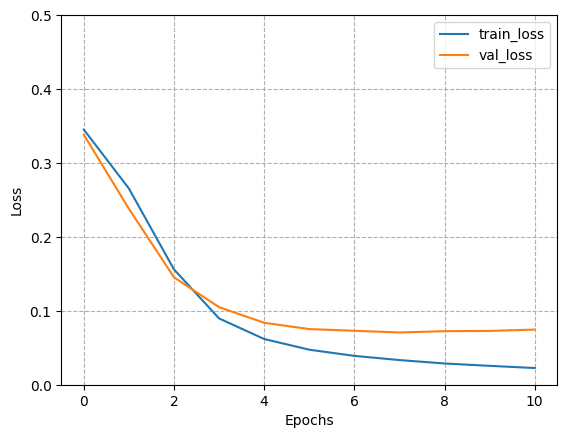

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='train_loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.grid(linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0,0.5])
    plt.legend()

plot_loss(history)

In [11]:
def build_model(hp):
    model=Sequential()
    layer_index=0
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=4)):
        if layer_index==0:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=2,max_value=10,step=2),
                           activation=hp.Choice(name='activation_layer'+str(i),values=['relu','elu']),
                           input_dim=x_train_svd.shape[1]))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.0,0.2,0.4])))
        else:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=2,max_value=10,step=2),
                            activation=hp.Choice(name='activation_layer_'+str(i),values=['relu','elu'])))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.0,0.2,0.4])))
            layer_index+=1

        model.add(Dense(1,activation='sigmoid',bias_initializer=tf.keras.initializers.Constant(initial_bias)))

        hp_learning_rate=hp.Choice('learning_rate',values=[1e-2,1e-3])
        model.compile(optimizer=tf.keras.optimizers.Adam(hp_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),metrics=METRICS)
        return model

tuner = kt.BayesianOptimization(build_model,
                        objective=kt.Objective("val_accuracy", direction="max"),
                        max_trials = 20,
                        directory='KT_dir',
                        project_name='KT_tuning',
                        overwrite=True)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,
                                             mode='max',restore_best_weights=True)
tuner.search_space_summary()

tuner.search(x_train_svd, y_train,
             validation_split=0.2, epochs=40, batch_size =32,callbacks=[early_stop])

Trial 20 Complete [00h 00m 04s]
val_accuracy: 0.9820573925971985

Best val_accuracy So Far: 0.9832535982131958
Total elapsed time: 00h 02m 06s


In [12]:
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()
history=best_model.fit(x_train_svd, y_train,
             validation_split=0.2, epochs=40, batch_size =32,callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 2406      
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 2413 (9.43 KB)
Trainable params: 2413 (9.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
105/105 [==============================] - 2s 7ms/step - loss: 0.0628 - accuracy: 0.9825 - precision: 0.9747 - recall: 0.8930 - prc: 0.9673 - roc: 0.9866 - val_loss: 0.0758 - val_accuracy: 0.9821 - val_precision: 0.9813 - val_recall: 0.8898 - val_prc: 0.9631 - val_roc: 0.9832


In [13]:
test_loss,test_acc,test_precision,test_recall,test_pr_curve,test_recall_curve=best_model.evaluate(x_test_svd,y_test)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test PR curve:', test_pr_curve)
print('Test ROC curve:',test_recall_curve)

44/44 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.9813 - precision: 0.9255 - recall: 0.9355 - prc: 0.9523 - roc: 0.9711
Test accuracy: 0.9813352227210999
Test precision: 0.9255319237709045
Test recall: 0.9354838728904724
Test PR curve: 0.9522645473480225
Test ROC curve: 0.9711427688598633


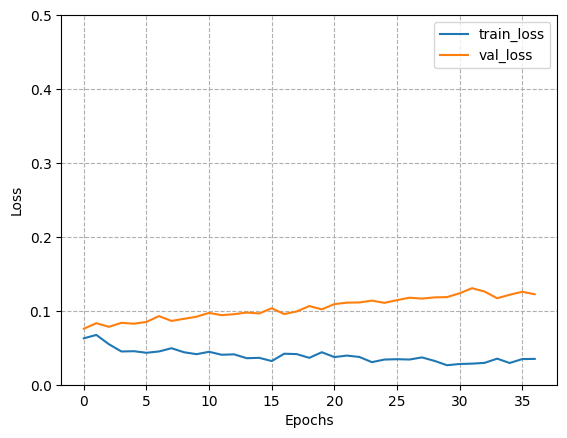

In [14]:
plot_loss(history)

In [17]:
batch_size=32
embedding_dim=512
vocab_size=5000
sequence_length=400

tf_train=tf.data.Dataset.from_tensor_slices((docs_train,y_train)).batch(batch_size)
tf_test=tf.data.Dataset.from_tensor_slices((docs_test,y_test)).batch(batch_size)


vectorize_layer=TextVectorization(max_tokens=vocab_size,input_shape=(1,),
                                  output_mode='int',output_sequence_length=sequence_length)

train_text=tf_train.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

tf_train=tf_train.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
tf_test=tf_test.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


validation_fraction = 0.25  # Adjust as needed
num_samples = tf.data.experimental.cardinality(tf_train).numpy()
num_validation_samples = int(validation_fraction * num_samples)

# Create a validation dataset
tf_validation = tf_train.take(num_validation_samples)
tf_train = tf_train.skip(num_validation_samples)


model=tf.keras.Sequential([
    vectorize_layer,
    Embedding(input_dim=vocab_size,output_dim=embedding_dim,name='embedding'),
    Dense(32,activation='elu'),
    Dense(16,activation='elu'),
    GlobalAveragePooling1D(),
    Dense(1,activation='sigmoid',bias_initializer=tf.keras.initializers.Constant(initial_bias))
])
model.summary()

METRICS=[
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.AUC(name='roc', curve='ROC')
]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,
                                             mode='max',restore_best_weights=True)


history=model.fit(tf_train, validation_data=tf_validation, epochs=40, callbacks=[early_stop])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 400)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 400, 512)          2560000   
                                                                 
 dense_8 (Dense)             (None, 400, 32)           16416     
                                                                 
 dense_9 (Dense)             (None, 400, 16)           528       
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 1)                

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


99/99 [==============================] - 18s 145ms/step - loss: 0.2954 - accuracy: 0.8960 - precision: 0.9055 - recall: 0.2668 - prc: 0.5467 - roc: 0.8076 - val_loss: 0.0930 - val_accuracy: 0.9648 - val_precision: 0.8092 - val_recall: 0.9462 - val_prc: 0.9668 - val_roc: 0.9951
Epoch 2/40
99/99 [==============================] - 8s 83ms/step - loss: 0.0692 - accuracy: 0.9762 - precision: 0.9495 - recall: 0.8724 - prc: 0.9671 - roc: 0.9905 - val_loss: 0.0367 - val_accuracy: 0.9912 - val_precision: 0.9549 - val_recall: 0.9769 - val_prc: 0.9938 - val_roc: 0.9989
Epoch 3/40
99/99 [==============================] - 12s 121ms/step - loss: 0.0250 - accuracy: 0.9933 - precision: 0.9928 - recall: 0.9582 - prc: 0.9937 - roc: 0.9985 - val_loss: 0.0288 - val_accuracy: 0.9932 - val_precision: 0.9695 - val_recall: 0.9769 - val_prc: 0.9916 - val_roc: 0.9951
Epoch 4/40
99/99 [==============================] - 15s 150ms/step - loss: 0.0092 - accuracy: 0.9975 - precision: 0.9976 - recall: 0.9838 - prc: 0

In [18]:
test_loss,test_acc,test_precision,test_recall,test_pr_curve,test_recall_curve=model.evaluate(tf_test)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test PR curve:', test_pr_curve)
print('Test ROC curve:',test_recall_curve)

44/44 [==============================] - 1s 29ms/step - loss: 0.1206 - accuracy: 0.9655 - precision: 0.8520 - recall: 0.8978 - prc: 0.9283 - roc: 0.9789
Test accuracy: 0.9655420184135437
Test precision: 0.8520408272743225
Test recall: 0.897849440574646
Test PR curve: 0.9282907843589783
Test ROC curve: 0.9789289832115173


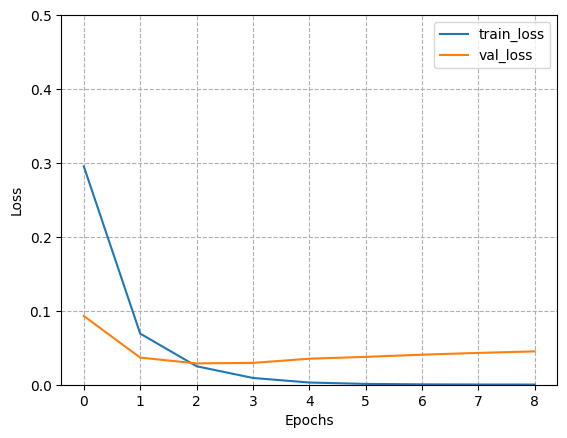

In [19]:
plot_loss(history)

In [20]:
embedding_dim=128

model=tf.keras.Sequential([
    vectorize_layer,
    Embedding(input_dim=vocab_size,output_dim=embedding_dim,name='embedding',mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(32,activation='elu'),
    Dense(16,activation='elu'),
    Dense(1,activation='sigmoid',bias_initializer=tf.keras.initializers.Constant(initial_bias))])


METRICS=[
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.AUC(name='roc', curve='ROC')
]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)


early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,
                                             mode='max',restore_best_weights=True)

history=model.fit(tf_train, validation_data=tf_validation, epochs=40, callbacks=[early_stop])


Epoch 1/40
99/99 [==============================] - 150s 1s/step - loss: 0.1128 - accuracy: 0.9623 - precision: 0.9127 - recall: 0.8005 - prc: 0.9217 - roc: 0.9738 - val_loss: 0.0704 - val_accuracy: 0.9795 - val_precision: 0.9823 - val_recall: 0.8538 - val_prc: 0.9652 - val_roc: 0.9892
Epoch 2/40
99/99 [==============================] - 87s 879ms/step - loss: 0.0138 - accuracy: 0.9965 - precision: 0.9907 - recall: 0.9838 - prc: 0.9956 - roc: 0.9973 - val_loss: 0.0592 - val_accuracy: 0.9902 - val_precision: 0.9545 - val_recall: 0.9692 - val_prc: 0.9520 - val_roc: 0.9882
Epoch 3/40
99/99 [==============================] - 72s 727ms/step - loss: 9.3670e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - prc: 1.0000 - roc: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9883 - val_precision: 0.9403 - val_recall: 0.9692 - val_prc: 0.9750 - val_roc: 0.9875
Epoch 4/40
99/99 [==============================] - 73s 736ms/step - loss: 0.0032 - accuracy: 0.9990 - precision: 0.9954 - recall: 

In [21]:
test_loss,test_acc,test_precision,test_recall,test_pr_curve,test_recall_curve=model.evaluate(tf_test)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test PR curve:', test_pr_curve)
print('Test ROC curve:',test_recall_curve)


44/44 [==============================] - 7s 163ms/step - loss: 0.1875 - accuracy: 0.9856 - precision: 0.9663 - recall: 0.9247 - prc: 0.9349 - roc: 0.9611
Test accuracy: 0.9856424927711487
Test precision: 0.966292142868042
Test recall: 0.9247311949729919
Test PR curve: 0.9349402189254761
Test ROC curve: 0.9610828161239624


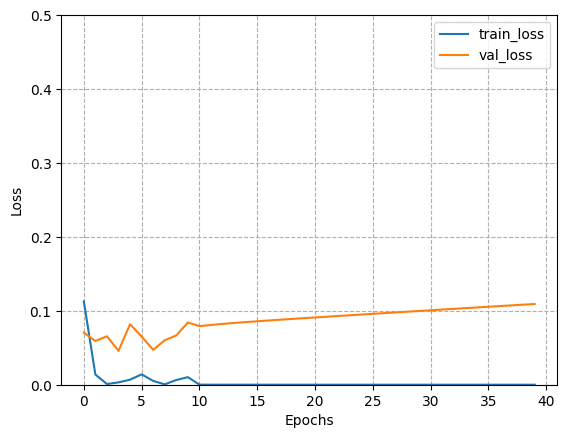

In [22]:
plot_loss(history)

In [23]:
embedding_dim=128

model=tf.keras.Sequential([
    vectorize_layer,
    Embedding(input_dim=vocab_size,output_dim=embedding_dim,name='embedding',mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    Dense(16,activation='elu'),
    Dense(1)])

model.summary()
METRICS=[
    keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.0),
    keras.metrics.Precision(name='precision',thresholds=0.0),
    keras.metrics.Recall(name='recall',thresholds=0.0),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.AUC(name='roc', curve='ROC')
]



model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,
                                             mode='max',restore_best_weights=True)


history=model.fit(tf_train, validation_data=tf_validation, epochs=40, callbacks=[early_stop])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 400)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 400, 128)          640000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 400, 128)          74496     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                      

In [24]:
test_loss,test_acc,test_precision,test_recall,test_pr_curve,test_recall_curve=model.evaluate(tf_test)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test PR curve:', test_pr_curve)
print('Test ROC curve:',test_recall_curve)


44/44 [==============================] - 10s 225ms/step - loss: 0.1245 - accuracy: 0.9684 - precision: 0.8318 - recall: 0.9570 - prc: 0.8353 - roc: 0.9664
Test accuracy: 0.9684134721755981
Test precision: 0.8317757248878479
Test recall: 0.9569892287254333
Test PR curve: 0.8352749347686768
Test ROC curve: 0.966356635093689


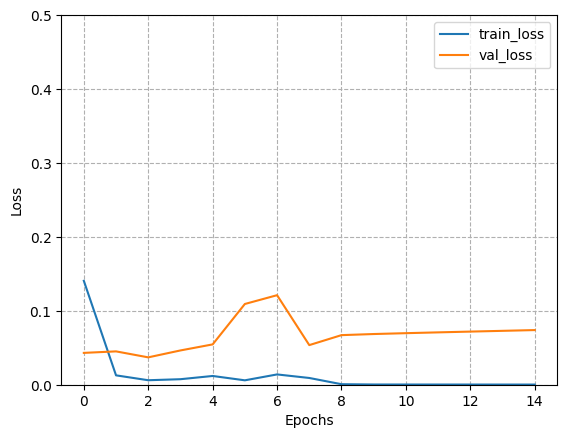

In [25]:
plot_loss(history)

In [8]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

#fasttext_model=fasttext.load_model('cc.en.300.bin')
embedding_matrix=np.zeros(shape=(vocab_size,300))

for idx,word in enumerate(vectorize_layer.get_vocabulary()):
  if idx<2:
    continue
  embedding_matrix[idx]=ft.get_word_vector(word)


embedding_dim=300

model=tf.keras.Sequential([
    vectorize_layer,
    Embedding(input_dim=vocab_size,output_dim=embedding_dim, weights=[embedding_matrix],
              name='embedding',mask_zero=True,trainable=False),
    Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    Bidirectional(tf.keras.layers.GRU(32)),
    Dense(16,activation='elu'),
    Dense(1)])

model.summary()
METRICS=[
    keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.0),
    keras.metrics.Precision(name='precision',thresholds=0.0),
    keras.metrics.Recall(name='recall',thresholds=0.0),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.AUC(name='roc', curve='ROC')
]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,
                                             mode='max',restore_best_weights=True)


history=model.fit(tf_train, validation_data=tf_validation, epochs=40, callbacks=[early_stop])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 400)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 400, 300)          1500000   
                                                                 
 bidirectional (Bidirection  (None, 400, 128)          140544    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                      

In [10]:
test_loss,test_acc,test_precision,test_recall,test_pr_curve,test_recall_curve=model.evaluate(tf_test)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test PR curve:', test_pr_curve)
print('Test ROC curve:',test_recall_curve)


44/44 [==============================] - 16s 359ms/step - loss: 0.0814 - accuracy: 0.9799 - precision: 0.8911 - recall: 0.9677 - prc: 0.8893 - roc: 0.9764
Test accuracy: 0.979899525642395
Test precision: 0.8910890817642212
Test recall: 0.9677419066429138
Test PR curve: 0.889288604259491
Test ROC curve: 0.9763610363006592


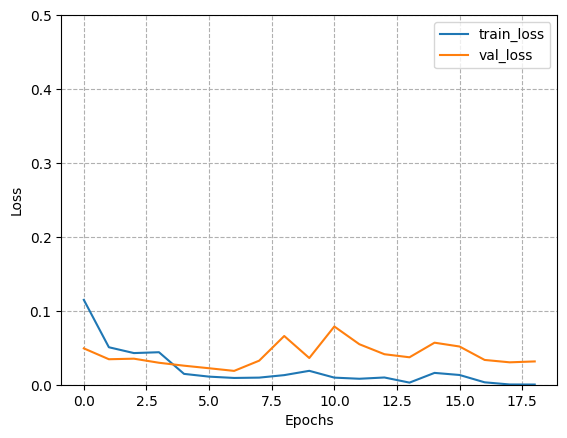

In [11]:
plot_loss(history)

In [12]:

model=tf.keras.Sequential([
    vectorize_layer,
    Embedding(input_dim=vocab_size,output_dim=embedding_dim,name='embedding',weights=[embedding_matrix],
              mask_zero=True,trainable=False),
    Bidirectional(LSTM(64)),
    Dense(32,activation='elu'),
    Dense(16,activation='elu'),
    Dense(1,activation='sigmoid',bias_initializer=tf.keras.initializers.Constant(initial_bias))])

model.summary()
METRICS=[
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.AUC(name='roc', curve='ROC')
]


model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,
                                             mode='max',restore_best_weights=True)

history=model.fit(tf_train, validation_data=tf_validation, epochs=40, callbacks=[early_stop])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 400)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 400, 300)          1500000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


99/99 [==============================] - 132s 1s/step - loss: 0.1275 - accuracy: 0.9588 - precision: 0.8791 - recall: 0.8097 - prc: 0.8845 - roc: 0.9726 - val_loss: 0.0600 - val_accuracy: 0.9746 - val_precision: 0.8768 - val_recall: 0.9308 - val_prc: 0.9780 - val_roc: 0.9959
Epoch 2/40
99/99 [==============================] - 113s 1s/step - loss: 0.0693 - accuracy: 0.9775 - precision: 0.9327 - recall: 0.9002 - prc: 0.9640 - roc: 0.9866 - val_loss: 0.0464 - val_accuracy: 0.9844 - val_precision: 0.8904 - val_recall: 1.0000 - val_prc: 0.9972 - val_roc: 0.9996
Epoch 3/40
99/99 [==============================] - 112s 1s/step - loss: 0.0380 - accuracy: 0.9883 - precision: 0.9624 - recall: 0.9513 - prc: 0.9840 - roc: 0.9945 - val_loss: 0.0245 - val_accuracy: 0.9922 - val_precision: 0.9692 - val_recall: 0.9692 - val_prc: 0.9910 - val_roc: 0.9953
Epoch 4/40
99/99 [==============================] - 112s 1s/step - loss: 0.0203 - accuracy: 0.9949 - precision: 0.9814 - recall: 0.9814 - prc: 0.9914 

In [13]:
test_loss,test_acc,test_precision,test_recall,test_pr_curve,test_recall_curve=model.evaluate(tf_test)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test PR curve:', test_pr_curve)
print('Test ROC curve:',test_recall_curve)


44/44 [==============================] - 15s 344ms/step - loss: 0.0686 - accuracy: 0.9770 - precision: 0.9140 - recall: 0.9140 - prc: 0.9668 - roc: 0.9854
Test accuracy: 0.9770280122756958
Test precision: 0.9139785170555115
Test recall: 0.9139785170555115
Test PR curve: 0.9667664766311646
Test ROC curve: 0.9853987693786621


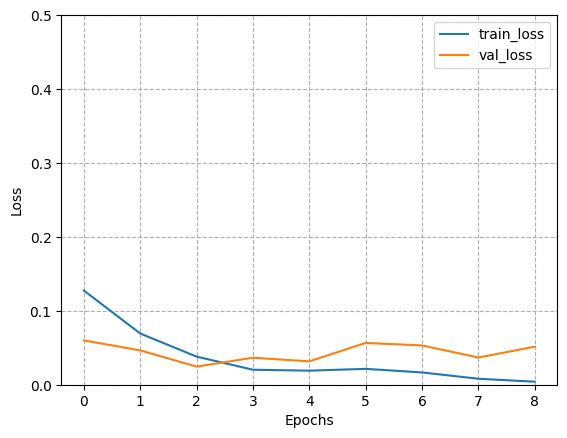

In [14]:
plot_loss(history)